In [1]:
import sys
import os
import math

In [2]:
import pysat
pysat.__version__

'0.1.7.dev12'

In [3]:
from dpll import DPLL
from utils import *

In [4]:
test_sats_path = 'test sudokus'

In [5]:
input_mapping = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9, 'A': 10, 'B': 11, "C": 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16}

inverse_input_mapping = {v:k for k, v in input_mapping.items()}

In [7]:
# found_assignments = sorted(solution[1], key=lambda x: x[0])

# matrix = np.zeros((sudoku_size, sudoku_size), dtype=int)
# for assignment in found_assignments:
#     if assignment[1]:
#         item = assignment[0]
#         matrix[int(item[0])-1, int(item[1])-1] = int(item[2])
        
# matprint(matrix)

# Experiment

In [8]:
from utils import exit_after

In [9]:
import random
random.seed(42)
import pandas as pd

In [10]:
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [13]:
def run_experiment(rules_path, setups_path, 
                   variable_selection_method='JWTS',
                   sudoku_num=50,
                   duration_limit_sec=300):
    rules = read_DIMACS(rules_path)
    
    with open(setups_path) as f:
        sudoku_list = f.readlines()
    sudoku_sample_indices = random.sample(range(0, len(sudoku_list)), sudoku_num)
    
    results_df = pd.DataFrame()

    for sudoku_index in sudoku_sample_indices:
        sudoku = sudoku_list[sudoku_index]
        
        sudoku_setup_CNF, sudoku_setup_DIMACS, sudoku_size = line2CNF(sudoku, inverse_input_mapping)
        
        clauses = rules + sudoku_setup_CNF
        solver = DPLL(clauses, 
                      variable_selection_method=variable_selection_method, 
                      verbose=0)
                
        time_limit = False
        start = time.time()
        try:
            solution = exit_after(duration_limit_sec)(solver.backtrack)(solver.clauses, partial_assignment=[], split_literal=tuple())     
        except:
            print(f'Was not solved in {duration_limit_sec} seconds. Skip')
            solution = False, None
            time_limit = True
        solution_time = time.time() - start
        
        givens, givens_num, row_fullness, col_fullness = get_setup_info(sudoku, sudoku_setup_CNF, sudoku_size)

        results_df.loc[len(results_df), ['rules_path', 'setups_path', 'setup_index', 'givens', 'givens_num', 'row_fullness', 'col_fullness', 'variable_selection_method', 'sat', 'solution', 'time_limit', 'time', 'backtracks']] = rules_path, setups_path, sudoku_index, givens, givens_num, row_fullness, col_fullness, variable_selection_method, *solution, time_limit, solution_time, solver.backtrack_counter
        display(results_df.tail(1))
        
    return results_df

In [14]:
results_df = run_experiment(os.path.join(test_sats_path, 'sudoku-rules-9x9.txt'),
                            os.path.join(test_sats_path, '1000 sudokus.txt'), # 1000 sudokus, 4x4
                            variable_selection_method='fullness',
                            sudoku_num=10,
                            duration_limit_sec=25,
              )
results_df.to_csv("10_launches_size_9_2.csv", index=False)

Found variable based on fullness: 461
Found variable based on fullness: 329


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
0,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,692.0,"{'.': 56, '2': 3, '6': 4, '5': 4, '1': 2, '8':...",25.0,"{1: 0, 2: 3, 3: 6, 4: 0, 5: 4, 6: 4, 7: 1, 8: ...","{1: 4, 2: 2, 3: 1, 4: 3, 5: 2, 6: 6, 7: 2, 8: ...",fullness,True,"[(262, True), (261, False), (263, False), (264...",False,24.381893,3.0


Found variable based on fullness: 825
Found variable based on fullness: 237
Found variable based on fullness: 222
Found variable based on fullness: 333
Found variable based on fullness: 157
Found variable based on fullness: 365
Found variable based on fullness: 222
Found variable based on fullness: 222
Found variable based on fullness: 741


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
1,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,758.0,"{'.': 55, '8': 4, '1': 4, '2': 3, '9': 4, '5':...",26.0,"{1: 3, 2: 3, 3: 4, 4: 4, 5: 4, 6: 0, 7: 2, 8: ...","{1: 2, 2: 3, 3: 4, 4: 3, 5: 3, 6: 3, 7: 2, 8: ...",fullness,True,"[(138, True), (131, False), (132, False), (133...",False,24.912475,17.0


Was not solved in 25 seconds. Skip


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
2,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,913.0,"{'3': 5, '4': 2, '8': 5, '.': 55, '2': 3, '6':...",26.0,"{1: 4, 2: 3, 3: 2, 4: 2, 5: 5, 6: 2, 7: 3, 8: ...","{1: 4, 2: 4, 3: 3, 4: 1, 5: 3, 6: 2, 7: 3, 8: ...",fullness,False,None,True,25.036097,1.0


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
3,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,558.0,"{'.': 56, '4': 2, '5': 4, '3': 4, '2': 3, '7':...",25.0,"{1: 3, 2: 3, 3: 3, 4: 3, 5: 1, 6: 3, 7: 3, 8: ...","{1: 2, 2: 3, 3: 2, 4: 5, 5: 3, 6: 2, 7: 4, 8: ...",fullness,True,"[(164, True), (161, False), (162, False), (163...",False,24.740726,1.0


Found variable based on fullness: 518
Found variable based on fullness: 687
Found variable based on fullness: 367


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
4,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,89.0,"{'.': 58, '8': 3, '3': 3, '6': 3, '9': 4, '7':...",23.0,"{1: 2, 2: 3, 3: 2, 4: 1, 5: 3, 6: 4, 7: 2, 8: ...","{1: 2, 2: 3, 3: 2, 4: 2, 5: 2, 6: 4, 7: 2, 8: ...",fullness,True,"[(128, True), (121, False), (122, False), (123...",False,24.781591,6.0


Found variable based on fullness: 826
Found variable based on fullness: 624


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
5,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,604.0,"{'.': 56, '9': 3, '8': 3, '3': 2, '4': 2, '5':...",25.0,"{1: 2, 2: 4, 3: 3, 4: 2, 5: 4, 6: 2, 7: 3, 8: ...","{1: 1, 2: 4, 3: 2, 4: 3, 5: 4, 6: 2, 7: 3, 8: ...",fullness,True,"[(129, True), (121, False), (122, False), (123...",False,22.494493,4.0


Found variable based on fullness: 648
Found variable based on fullness: 655
Found variable based on fullness: 368
Found variable based on fullness: 435
Found variable based on fullness: 655
Found variable based on fullness: 368
Found variable based on fullness: 387
Found variable based on fullness: 924
Found variable based on fullness: 317
Found variable based on fullness: 385
Found variable based on fullness: 388
Was not solved in 25 seconds. Skip


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
6,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,432.0,"{'.': 56, '1': 1, '9': 5, '2': 4, '5': 2, '4':...",25.0,"{1: 3, 2: 1, 3: 4, 4: 4, 5: 1, 6: 2, 7: 1, 8: ...","{1: 2, 2: 2, 3: 2, 4: 3, 5: 4, 6: 4, 7: 4, 8: ...",fullness,False,None,True,25.01175,21.0


Found variable based on fullness: 468


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
7,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,32.0,"{'.': 58, '6': 4, '4': 3, '5': 3, '2': 2, '8':...",23.0,"{1: 2, 2: 3, 3: 3, 4: 3, 5: 2, 6: 3, 7: 3, 8: ...","{1: 4, 2: 3, 3: 3, 4: 1, 5: 2, 6: 3, 7: 3, 8: ...",fullness,True,"[(146, True), (141, False), (142, False), (143...",False,21.958712,2.0


Found variable based on fullness: 253
Found variable based on fullness: 184


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
8,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,30.0,"{'5': 4, '3': 2, '.': 58, '9': 4, '7': 3, '1':...",23.0,"{1: 4, 2: 1, 3: 2, 4: 2, 5: 2, 6: 5, 7: 1, 8: ...","{1: 2, 2: 3, 3: 3, 4: 1, 5: 3, 6: 3, 7: 3, 8: ...",fullness,True,"[(115, True), (111, False), (112, False), (113...",False,23.65693,4.0


Found variable based on fullness: 379
Found variable based on fullness: 394
Found variable based on fullness: 346
Found variable based on fullness: 394
Found variable based on fullness: 319


,rules_path,setups_path,setup_index,givens,givens_num,row_fullness,col_fullness,variable_selection_method,sat,solution,time_limit,time,backtracks
9,test sudokus/sudoku-rules-9x9.txt,test sudokus/1000 sudokus.txt,95.0,"{'.': 58, '8': 4, '1': 3, '3': 3, '7': 3, '2':...",23.0,"{1: 3, 2: 1, 3: 3, 4: 1, 5: 3, 6: 5, 7: 3, 8: ...","{1: 2, 2: 2, 3: 2, 4: 1, 5: 3, 6: 4, 7: 3, 8: ...",fullness,True,"[(168, True), (161, False), (162, False), (163...",False,24.540924,10.0


In [1]:
pa = [('124', True), ('121', False), ('111', True)]

row_fullness = {i: v for i, v in enumerate(row_fullness, 1)}

NameError: name 'row_fullness' is not defined

In [64]:
row_assignments, col_assignments

({1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 {1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})

In [65]:
row_fullness

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [68]:
import functools
import operator
import collections

functools.reduce(operator.add, map(collections.Counter, [row_assignments, row_fullness]))

Counter({1: 3, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9})

In [ ]:
## Experiment takes number of runs. In each run a number of sudoku's is solved. The average backtracks and time of solving the sudoku's 
## is stored. Eventually, the average for every run is stored in d. 

# To change method, adjust code above
def experiment_runs(sudoku_num, run_num):
    avg_time = []
    avg_bt = []
    ex_run = []
    run = 1
    for i in range (0,run_num):
        results_df = run_experiment(os.path.join(test_sats_path, 'sudoku-rules-9x9.txt'),
        os.path.join(test_sats_path, '1000 sudokus.txt'), # 1000 sudokus, 4x4
        sudoku_num)
        avg_time.append(np.average(results_df.time))
        avg_bt.append(np.average(results_df.backtracks))
        ex_run.append(run)
        run += 1
    dict = {'Run with ' + str(sudoku_num) + 'setups': ex_run , 'Time': avg_time, 'Backtracks': avg_bt}
    d = pd.DataFrame(dict)

experiment_runs(10,1)

In [ ]:
## Calculate the distribution of amount of givens in the test-sudoku's
with open(os.path.join(test_sats_path, '1000 sudokus.txt')) as f:
    amount_given = []
    lines = f.readlines()
    for line in lines:
        dots = line.count('.')
        given = 81 - dots
        amount_given.append(given)
    k =  dict((x, amount_given.count(x)) for x in set(amount_given))
    print(k)
    

In [ ]:
## Store 1 set-up example for each amount of given

with open(os.path.join(test_sats_path, '1000 sudokus.txt')) as f:
    dict_giv = {}
    for line in f.readlines():
        dots = line.count('.')
        given = 81 - dots
        dict_giv[given] = line
    print(dict_giv)

# Can we apply each method on this dict of 1 setup per amount-of-given? 

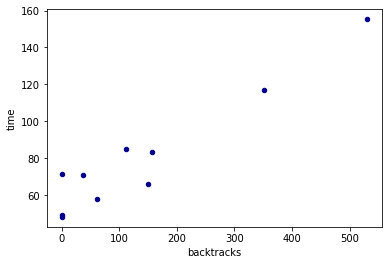

In [28]:
import matplotlib.pyplot as plt
ax1 = results_df.plot.scatter(x='backtracks',
                      y='time',
                      c='DarkBlue')